# Predicting Credit Card Fraud

In [1]:
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, lasso_path, LassoCV, Ridge, Lasso
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from statsmodels.api import OLS

import warnings
warnings.filterwarnings("ignore")

% matplotlib inline

C:\Users\fisol\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\fisol\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
cc = pd.read_csv('C:/Users/fisol/Desktop/Class Docs/DATA 803/Python II - Johnson/Class 3/HW/creditcard.csv') 

In [3]:
# cc.head(10)

In [4]:
#shuffling the dataset
cc = shuffle(cc, random_state=0)

In [5]:
#checking the amount of fraud cases in the dataset. 
cc.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
#creating my predictors and response variables
X = cc[['Time','V1','V2','V3','V4','V5','V6','V7', 'V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
        'V21','V22','V23','V24', 'V25','V26','V27','V28','Amount',]]
y = cc['Class']

In [7]:
#checking the shape of both X and y
print (X.shape, y.shape)

(284807, 30) (284807,)


In [8]:
#standardizing all the predictors.
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
#splitting the data into train and test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
#checking the shape of the train and test split data
print (Xtr.shape, Xte.shape, ytr.shape, yte.shape )

(227845, 30) (56962, 30) (227845,) (56962,)


In [11]:
#logistic regression model using l2 penalty
trainmodel01 = LogisticRegression(random_state=0).fit(Xtr,ytr)
trainpred01 = trainmodel01.predict(Xte)

In [12]:
#The Rsquared score of the model
print(trainmodel01.score(Xte, yte))  

0.999227555212


In [13]:
print(classification_report(yte, trainpred01)) 
print('Confusion Matrix:\n\n %s\n' % confusion_matrix(yte, trainpred01));

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56869
          1       0.90      0.59      0.71        93

avg / total       1.00      1.00      1.00     56962

Confusion Matrix:

 [[56863     6]
 [   38    55]]



** Running a Grid Search to find the best choice of C for the different metrics **

In [14]:
#create a wide list of C's
cs = [10, 100, 1, 0.1, 0.01, 0.001, 0.0001]  
print(cs)

[10, 100, 1, 0.1, 0.01, 0.001, 0.0001]


In [15]:
lm = LogisticRegression(random_state=0) 

#**********Run Grid search for precision***************** 

grid = GridSearchCV(estimator=lm, param_grid=dict(C=cs), scoring='precision', verbose=1, cv=5, n_jobs=-1, refit=True)
grid.fit(Xtr, ytr)  

print("*********RESULTS FOR PRECISION************")
print("Best score: %s" % grid.best_score_)
print("Best choice of C: %s" % grid.best_estimator_.C)

#***********Run Grid search for Accuracy*****************

grid_accuracy = GridSearchCV(estimator=lm, param_grid=dict(C=cs), scoring='accuracy', verbose=1, cv=5, n_jobs=-1, refit=True)
grid_accuracy.fit(Xtr, ytr)

print("*********RESULTS FOR ACCURACY************")
print("Best score: %s" % grid_accuracy.best_score_)
print("Best choice of C: %s" % grid_accuracy.best_estimator_.C)

#************Run Grid search for Roc_Auc*****************

grid_auc = GridSearchCV(estimator=lm, param_grid=dict(C=cs), scoring='roc_auc', verbose=1, cv=5, n_jobs=-1, refit=True)
grid_auc.fit(Xtr, ytr)  # fit 

print("*********RESULTS FOR ROC_AUC************")
print("Best score: %s" % grid_auc.best_score_)
print("Best choice of C: %s" % grid_auc.best_estimator_.C)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   40.0s finished


*********RESULTS FOR PRECISION************
Best score: 0.8742681441596377
Best choice of C: 0.01
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   40.1s finished


*********RESULTS FOR ACCURACY************
Best score: 0.9991573218635476
Best choice of C: 0.1
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   40.6s finished


*********RESULTS FOR ROC_AUC************
Best score: 0.9797313990450267
Best choice of C: 0.01


** I am selecting C of 0.01 to build my model because it is the best choice for both ROC-AUC and Precision **

In [16]:
#creating a new list with the seleceted best choice of C
cs2 = [0.01]

In [17]:
#Build new model using best choice of C and 4 Folds for cross validation.
final_model = LogisticRegressionCV(penalty='l2', Cs=cs2, cv= 4, n_jobs=-1, verbose=1, scoring='roc_auc').fit(Xtr, ytr)

[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.0s finished


In [18]:
#Make predictions on the test data set 
final_preds = final_model.predict(Xte)

In [19]:
#Get the actual probablilities for every prediction
final_prob_preds = final_model.predict_proba(Xte)

In [20]:
#Check the strength of the model using KFold to ensure that there is uniformity across the data and that the best model was built.
tuned_final_scores = cross_val_score(final_model, X, y, cv= 5, scoring='roc_auc',n_jobs=-1, verbose=1)
print(tuned_final_scores)


[ 0.96781383  0.98833507  0.97761752  0.98033584  0.98739487]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished


In [21]:
print("Accuracy of my model based on ROC AUC Metric is: ", np.mean(tuned_final_scores))

Accuracy of my model based on ROC AUC Metric is:  0.98029942734


**The AUC score: **

In [22]:
roc_auc_score(yte, final_prob_preds[:,1], average='macro', sample_weight = None)

0.98315445590195316

** Plotting an ROC Curve for Illustration Purposes **

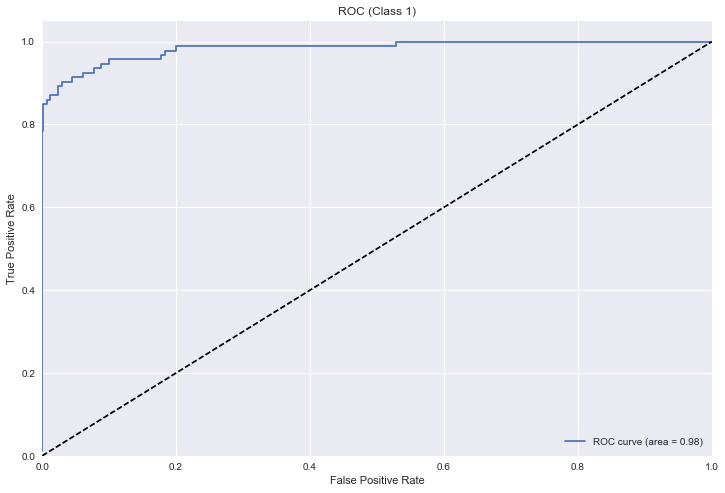

In [23]:
def plot_roc(actual, predicted):
    fpr, tpr, thr = roc_curve(actual, predicted)
    roc_auc = auc(fpr, tpr)
    figsize(12, 8)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (Class 1)')
    plt.legend(loc="lower right");
    
plot_roc(yte, final_prob_preds[:,1])

# Number 2
Build the best regularized linear model (lasso or ridge) you can to predict the amount of each charge. Use  kk -fold cross-validation to assess the quality of the model. Use MSE as your primary metric. How does your model compare to the null prediction? (In this case, take the null prediction to be the mean value of the target variable).

In [24]:
#creating my predictors and response variables
X2 = cc[['Time','V1','V2','V3','V4','V5','V6','V7', 'V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
        'V21','V22','V23','V24', 'V25','V26','V27','V28']]
y2 = cc['Amount']

In [25]:
#standardizing all the predictors.
scaler = StandardScaler()
X2s = scaler.fit_transform(X2)

In [26]:
#splitting the data into train and test
X2tr, X2te, y2tr, y2te = train_test_split(X2s, y2, test_size=0.2, random_state=0)

In [27]:
#Base model and test for best possible alpha value
model_lasso = LassoCV(n_jobs=-1, cv = 5, random_state=0, normalize=True, verbose=1, copy_X = True)
model_lasso.fit(X2tr, y2tr)


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=True, positive=False,
    precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
    verbose=1)

In [28]:
#show the best alpha value 
model_lasso.alpha_

0.00027981669603212734

In [29]:
model_lasso.coef_

array([  -0.41412588,  -56.01186297, -132.2935986 ,  -52.42362614,
         24.20615386,  -96.4157684 ,   53.94040863,   99.22839094,
        -25.79869614,  -11.09455336,  -25.36575472,   -0.16283123,
         -2.21937579,    1.07617269,    8.4653934 ,   -0.78584699,
         -0.90707232,    1.84026148,    9.05718739,  -14.11545336,
         85.63169641,   26.86867455,  -16.02003267,  -28.18706836,
          1.11168983,  -11.92122662,   -0.7256215 ,    7.4352915 ,
          2.45240134])

In [30]:
#Making predictions on the test data
lasso_preds = model_lasso.predict(X2te)

In [31]:
#The Rsquared score of the model:
model_lasso.score(X2te, y2te)

0.92184258742589309

In [32]:
#Getting the null value
null = y2te.mean() 

**The MSE of the current model: **

In [33]:
print("The mean square error for the model predictions is: ",mean_squared_error(y2te, lasso_preds))

The mean square error for the model predictions is:  4652.90138847


In [34]:
#Creating a list the length of my test data filled with the null value 
null_preds = []
for i in range (0,len(y2te)):
    null_preds.append(null)

** The MSE of the Null Predictions: **

In [35]:
print("The mean square error for the null predictions is: ",mean_squared_error(y2te, null_preds))

The mean square error for the null predictions is:  59532.4388977


** Cross Validation with KFold **

In [36]:
#Check the strength of the lasso model using KFold and mean square error metric.
crossval_lasso = cross_val_score(model_lasso, X2, y2, cv= 5, scoring='neg_mean_squared_error',n_jobs=-1, verbose=1)
print(-crossval_lasso)

[ 5714.08167435  5788.21648086  5153.49523975  5292.96347036  4470.95724694]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


In [37]:
#Correcting the negative signs on the MSE cross evaluation
new_crossval_lasso = -crossval_lasso
print("The average MSE for the model based on the dataset is: ",np.mean(new_crossval_lasso))

The average MSE for the model based on the dataset is:  5283.94282245


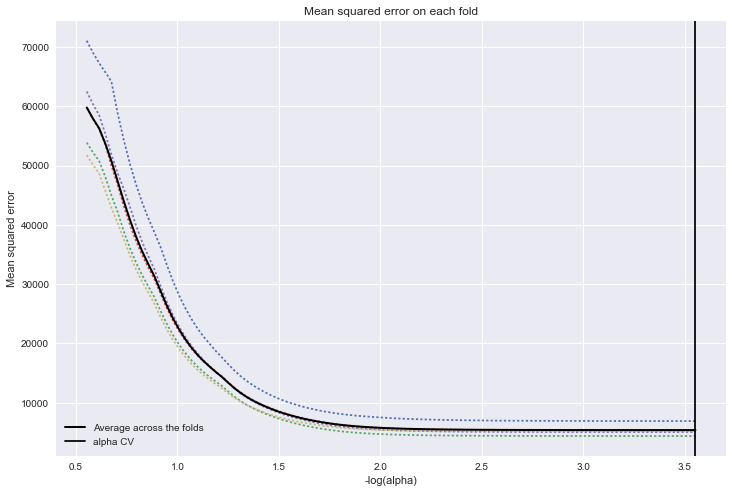

In [38]:
#plot mean square error for each fold
xaxis = -np.log10(model_lasso.alphas_)
plt.figure()
plt.plot(xaxis, model_lasso.mse_path_, ':')
plt.plot(xaxis, model_lasso.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model_lasso.alpha_), linestyle='-', color='k', label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
plt.show()

# Reducing The Variables

In [39]:
#Testing with different alphas to reduce the number of variables and keep only strong predictors
Test_Lasso = Lasso(alpha = 2 ).fit(X2tr, y2tr)

In [40]:
pd.Series(Test_Lasso.coef_, index=X2.columns)

Time     -0.000000
V1      -54.257390
V2     -130.490190
V3      -50.427728
V4       22.394238
V5      -94.669335
V6       52.116966
V7       97.376624
V8      -23.951204
V9       -9.203466
V10     -23.479807
V11      -0.000000
V12      -0.421118
V13       0.000000
V14       6.602055
V15      -0.000000
V16      -0.000000
V17       0.000000
V18       7.142826
V19     -12.260134
V20      83.695478
V21      24.916376
V22     -14.208316
V23     -26.427850
V24       0.000000
V25      -9.962728
V26      -0.000000
V27       5.561890
V28       0.544284
dtype: float64

**  Alpha set at 2 turned out to give the best results  **

In [41]:
drop = np.isclose(Test_Lasso.coef_, np.zeros(shape=Test_Lasso.coef_.shape)).flatten()
keep = []
for i in range(len(drop)):
    if not drop[i]:
        keep.append(i)

In [42]:
keep

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 18, 19, 20, 21, 22, 23, 25, 27, 28]

In [43]:
final_lasso = LassoCV(n_jobs=-1, cv = 5, random_state=0, normalize=True, verbose=1, copy_X = True).fit(X2s[:,keep], y2)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


** Cross Validation using KFold and mean square error scoring metric  **

In [44]:
final_lasso_kfold = cross_val_score(final_lasso, X2s[:, keep], y2, cv = 6, scoring='neg_mean_squared_error', n_jobs=-1)

In [45]:
print(-final_lasso_kfold)
print("The average value for Mean Square Error on the dataset after Cross Evaluation is: ",np.mean(-final_lasso_kfold))

[ 6077.19846002  6119.94733752  4495.79142826  5602.08518191  5133.5776776
  4311.04996152]
The average value for Mean Square Error on the dataset after Cross Evaluation is:  5289.94167447


In [46]:
lasso2_preds = final_lasso.predict(X2te[:, keep])

In [47]:
final_lasso.score(X2te[:, keep], y2te)

0.92210397882843453

**  MSE of final model with reduced predictors  **

In [48]:
mean_squared_error(y2te, lasso2_preds)

4637.3401207732977

Upon using Lasso regularization to detect the weak predictors and removing them from the model, I got an MSE of **4637.3** which is better than the MSE of **4924.6** from my initial model.

The MSE is also much better than that of the Null Predictions. Overall, I beleive that I was able to use Lasso Regularization to improve upon my linear model.
